In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['sample_submission.csv', 'train.csv', 'test.csv']


<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [ ]:
# read train 
train = pd.read_csv("../input/train.csv")
print(train.shape)
train.head()

In [ ]:
# read test 
test= pd.read_csv("../input/test.csv")
print(test.shape)
test.head()

In [4]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

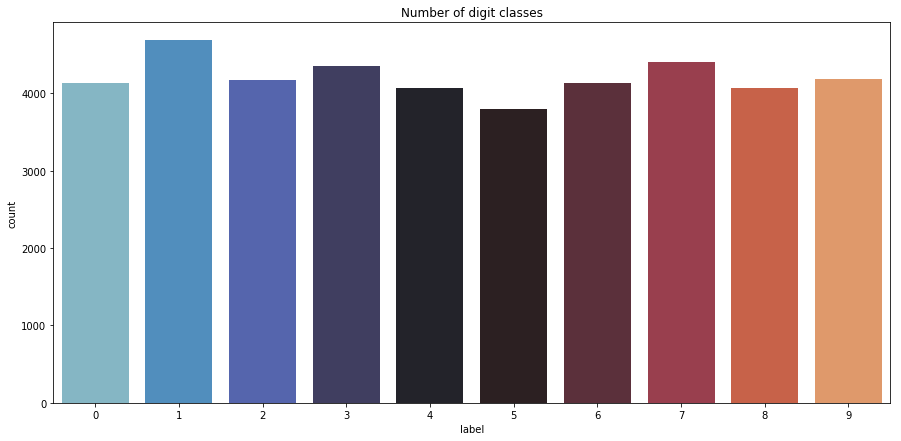

In [5]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

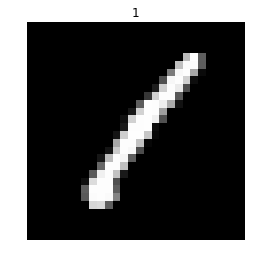

In [6]:
# plot some samples
img = X_train.iloc[0].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

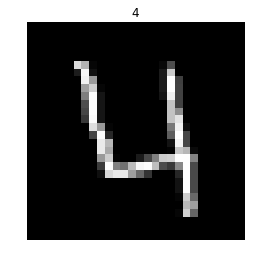

In [7]:
# plot some samples
img = X_train.iloc[3].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

<a id="2"></a>
## Normalization, Reshape and Label Encoding 
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28) 
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [9]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [10]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

Using TensorFlow backend.


<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 10%.
* train size is 90%.

In [11]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


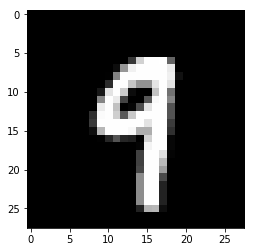

In [12]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="10"></a>
## Implementing with Keras

In [13]:
# 
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
epochs = 10  # for better result increase the epochs
batch_size = 250

In [17]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

<a id="16"></a>
### Fit the model

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
151/151 [==============================] - 27s 180ms/step - loss: 1.0760 - acc: 0.6413 - val_loss: 0.2090 - val_acc: 0.9460
Epoch 2/10
151/151 [==============================] - 26s 175ms/step - loss: 0.4263 - acc: 0.8654 - val_loss: 0.1289 - val_acc: 0.9638
Epoch 3/10
151/151 [==============================] - 26s 175ms/step - loss: 0.3082 - acc: 0.9045 - val_loss: 0.0969 - val_acc: 0.9721
Epoch 4/10
151/151 [==============================] - 26s 172ms/step - loss: 0.2624 - acc: 0.9185 - val_loss: 0.0853 - val_acc: 0.9738
Epoch 5/10
151/151 [==============================] - 26s 174ms/step - loss: 0.2331 - acc: 0.9273 - val_loss: 0.0764 - val_acc: 0.9779
Epoch 6/10
151/151 [==============================] - 27s 176ms/step - loss: 0.2102 - acc: 0.9349 - val_loss: 0.0683 - val_acc: 0.9810
Epoch 7/10
151/151 [==============================] - 27s 177ms/step - loss: 0.1953 - acc: 0.9384 - val_loss: 0.0643 - val_acc: 0.9821
Epoch 8/10
151/151 [==============================] - 2

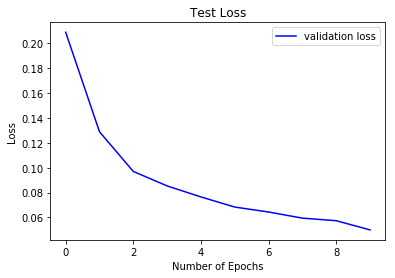

In [19]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

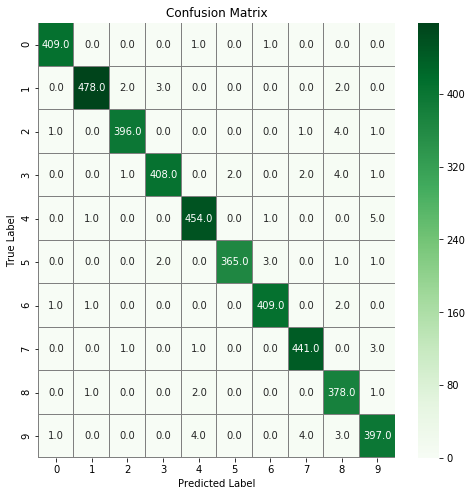

In [20]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()